### 定义模型

注意DDGP中critic网络的输入是state加上action。

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim = 256, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### 定义经验回放

In [122]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

### 定义策略

In [123]:
import torch.optim as optim
import numpy as np

class Policy:
    def __init__(self, cfg):
        self.device = torch.device(cfg.device)
        self.critic = Critic(cfg.state_dim, cfg.action_dim).to(self.device)
        self.target_critic = Critic(cfg.state_dim, cfg.action_dim).to(self.device)
        self.actor = Actor(cfg.state_dim, cfg.action_dim).to(self.device)
        self.target_actor = Actor(cfg.state_dim, cfg.action_dim).to(self.device)
        
        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),  lr=cfg.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.memory = ReplayBuffer(cfg.buffer_size)
        self.batch_size = cfg.batch_size
        self.gamma = cfg.gamma  # 折扣因子
        self.tau = cfg.tau  # 软更新参数
        self.action_high = cfg.action_space.high[0]
        self.action_low = cfg.action_space.low[0]
        self.action_scale = (self.action_high - self.action_low) / 2
        self.action_bias = (self.action_high + self.action_low) / 2

    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        mu = self.actor(state)
        action = mu * self.action_scale + self.action_bias
        return action.cpu().detach().numpy()[0]
    
    @torch.no_grad()
    def predict_action(self, state):
        ''' 用于预测，不需要计算梯度
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        mu = self.actor(state)
        action = mu * self.action_scale + self.action_bias
        return action.cpu().detach().numpy()[0]
    
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中中随机采样一个批量的transition
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        # 注意看伪代码，这里的actor损失就是对应策略即actor输出的action下对应critic值的负均值
        actor_loss = self.critic(state, self.actor(state))
        actor_loss = - actor_loss.mean()

        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())
        # 这里的expected_value就是伪代码中间的y_i  
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)
        # 注意这里的action是经过缩放和平移的，所以要逆操作
        action = (action - self.action_bias) / self.action_scale
        actual_value = self.critic(state, action)
        critic_loss = nn.MSELoss()(actual_value, expected_value.detach())
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 各自目标网络的参数软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

### 定义OU噪声

In [124]:
class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.action_dim) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

### 定义训练

In [125]:


import gymnasium as gym

def train(cfg):
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.shape[0])
    ou_noise = OUNoise(env.action_space)  # 动作噪声
    policy = Policy(cfg)
    rewards,frames = [],[]
    for i_ep in range(cfg.train_eps):
        state, _ = env.reset()
        ou_noise.reset()
        ep_reward = 0
        for i_step in range(cfg.max_steps):
            action = policy.sample_action(state)
            action = ou_noise.get_action(action, i_step+1) 
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, truncated))  # 保存transition
            state = next_state  # 更新下一个状态
            ep_reward += reward
            policy.memory.push((state, action, reward, next_state, truncated))
            policy.update()
            state = next_state
            if truncated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}

### 设置参数

In [126]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'DDPG' # 算法名称
        self.env_id = 'Pendulum-v1' # 环境id
        self.mode = 'train'
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 200 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 100000 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.99 # 折扣因子
        self.buffer_size = 8000 # 经验回放池的容量
        self.hidden_dim = 256 # 神经网络的隐藏层维度
        self.batch_size = 128 # 批次大小
        self.critic_lr = 1e-3 
        self.actor_lr = 1e-4
        self.tau = 1e-2
        self.critic_hidden_dim = 256
        self.actor_hidden_dim = 256
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda'

### 开始训练

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        DDPG        	   <class 'str'>    
       env_id       	    Pendulum-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	       100000       	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
    buffer_size     	        8000        	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
     batch_size     	        128         	   <class 'int'>    
     critic_lr      	       0.001        	  <class 'float'>   
      actor_lr      	       0.0001       	  <class 'float'>   
        tau         	        0.01        	  <class 'float'>   
 critic_hidden_dim  	        256      

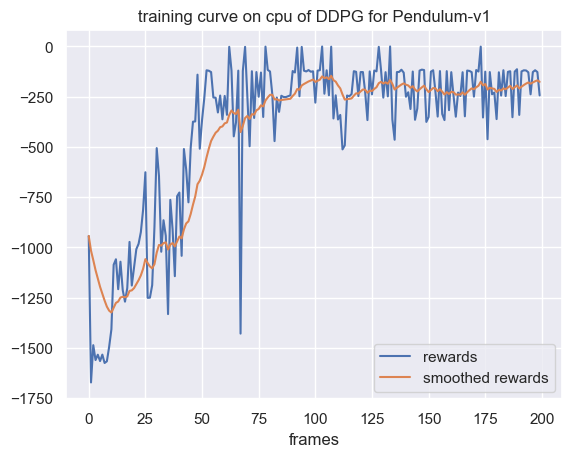

In [128]:
# 获取参数
cfg = Config() 
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])